In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
from sasc import analyze_helper
import sasc.viz
from sasc.config import FMRI_DIR, RESULTS_DIR
import dvu
import sasc.viz
dvu.set_style()

### Barplots

In [ ]:
# default
uts02 = joblib.load(join(RESULTS_DIR, 'processed', 'pilot_default_means.pkl'))
uts03 = joblib.load(join(RESULTS_DIR, 'processed', 'pilot3_default_means.pkl'))
sasc.viz.barplot_default([uts02['diag_means'], uts03['diag_means']],
                         [uts02['off_diag_means'], uts03['off_diag_means']],
                         pilot_name='full_', expls=[], annot_points=False)

# interactions
uts02 = joblib.load(join(RESULTS_DIR, 'processed',
                    'pilot2_interactions_means.pkl'))
uts03 = joblib.load(join(RESULTS_DIR, 'processed',
                    'pilot3_interactions_means.pkl'))
sasc.viz.barplot_interaction([uts02['diag_means'], uts03['diag_means']],
                             [uts02['off_diag_means'], uts03['off_diag_means']],
                             [uts02['diag_means_interaction'],
                              uts03['diag_means_interaction']],
                             [uts02['off_diag_means_interaction'],
                              uts03['off_diag_means_interaction']],
                             pilot_name='full_')

# polysemantic
uts02 = joblib.load(join(RESULTS_DIR, 'processed', 'pilot2_poly_means.pkl'))
uts03 = joblib.load(join(RESULTS_DIR, 'processed', 'pilot3_poly_means.pkl'))
sasc.viz.barplot_polysemantic([uts02['diag_means'], uts03['diag_means']],
                              [uts02['off_diag_means'], uts03['off_diag_means']],
                              pilot_name='full_', expls=[], annot_points=False)

### Stability scores

In [ ]:
voxel_scores1 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot_default_voxel_scores.pkl'))
voxel_scores2 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot3_default_voxel_scores.pkl'))


def plot_line_with_corr(voxel_scores, i=0, cs=['C0', 'gray'], markers=['o', '^']):
    x = voxel_scores["stability_score"]
    y = voxel_scores["driving_score"]
    plt.plot(x, y, markers[i], color=cs[i], )

    corr = np.corrcoef(x, y)[0, 1]
    plt.text(
        x.mean(),
        y.mean(),
        f"$p$={corr:.2f}",
        transform=plt.gca().transAxes,
        color=cs[i],
    )

    # plot line of best fit
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b, color=cs[i], alpha=0.5)

    plt.ylabel("Driving score")
    plt.xlabel("Stability score")


plt.figure(figsize=(6, 5))
plot_line_with_corr(voxel_scores1, i=0)
plot_line_with_corr(voxel_scores2, i=1)


plt.savefig(join(RESULTS_DIR, 'figs/misc',
            'full_stability_score.pdf'), bbox_inches='tight')
plt.show()

### Story scores

In [34]:
df_big[['setting', 'subj']].apply(tuple, axis=1)

0         (default, S2)
1         (default, S2)
2         (default, S2)
3         (default, S2)
4         (default, S2)
5         (default, S2)
0         (default, S3)
1         (default, S3)
0    (interactions, S2)
1    (interactions, S2)
0    (interactions, S3)
1    (interactions, S3)
0    (polysemantic, S2)
1    (polysemantic, S2)
0    (polysemantic, S3)
1    (polysemantic, S3)
dtype: object

<>:55: DeprecationWarning: invalid escape sequence '\s'
<>:55: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_1023126/2818657747.py:55: DeprecationWarning: invalid escape sequence '\s'
  plt.ylabel('Mean voxel response ($\sigma_f$)')


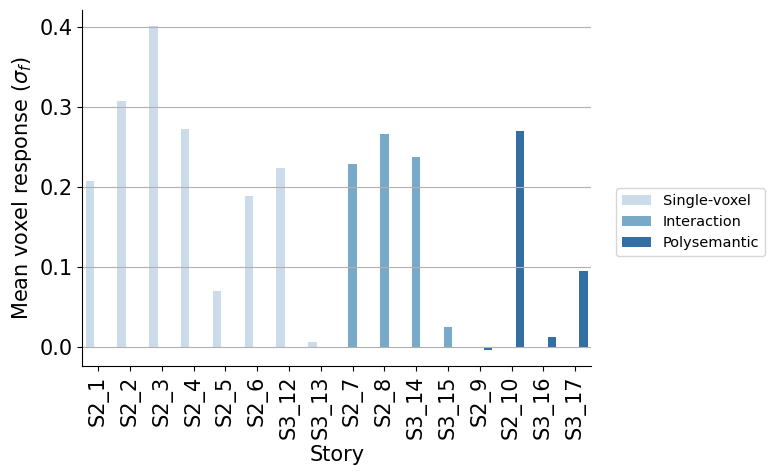

In [78]:
default02 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot_default_story_scores.pkl'))
default03 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot3_default_story_scores.pkl'))
interactions02 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot2_interactions_story_scores.pkl'))
interactions03 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot3_interactions_story_scores.pkl'))
polysemantic02 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot2_poly_story_scores.pkl'))
polysemantic03 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot3_poly_story_scores.pkl'))


dfs = [default02, default03, interactions02,
       interactions03, polysemantic02, polysemantic03]
subj = ['S2', 'S3', 'S2', 'S3', 'S2', 'S3']
setting = ['Single-voxel', 'Single-voxel', 'Interaction', 'Interaction',
           'Polysemantic', 'Polysemantic']
df_big = []
for df in dfs:
    # make barplot comparing driving and baseline
    d = df.melt(id_vars='story', value_vars=[
        'driving', 'baseline'], var_name='condition', value_name='mean')
    d['subj'] = subj.pop(0)
    d['setting'] = setting.pop(0)
    d['story'] = d.apply(lambda x: x['subj'] + '_' + x['story'], axis=1)
    df_big.append(deepcopy(d))

df_big = pd.concat(df_big)
df_big['story'] = df_big['story'].str.replace('GenStory', '')
df_big = df_big[df_big['condition'] == 'driving']


# set xticklabels rotated
plt.figure(figsize=(8, 5))
plt.grid()

# shade bars by subj
sns.barplot(data=df_big, x='story', y='mean',
            hue='setting',
            width=0.8,
            palette=sns.color_palette("Blues", 3),
            # hue=df_big[['setting', 'subj']].apply(tuple, axis=1).apply(str)
            )

# move legend to right
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=2,
           borderaxespad=0., fontsize='x-small')

plt.xticks(rotation=90, va='top')
plt.xlabel('Story')


plt.ylabel('Mean voxel response ($\sigma_f$)')
plt.savefig(join(RESULTS_DIR, 'figs/main', 'full_story_breakdown.pdf'))

plt.show()